# Brownian Dynamics

In [1]:
from math import pi, sqrt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random as rnd
from sys import exit

In [2]:
# These are the only variables that we have to set
num_of_particles = 2**3 # Must be a cube
packing_fraction = 0.2
time_window = 100000
r_partition = 2**8
delta_t = 0.00001
therm_time = 200000
iseed = 1234567890

In [3]:
# Constants
l_repulsive = 50.0
l_attractive = 49.0
epi = 1.4737
pbc = 1.0 # Periodic boundary condition
diameter = 6.0 * packing_fraction / pi
mean_distance = diameter**(-1.0 / 3.0)
box_length = (num_of_particles / diameter)**(1.0 / 3.0)
a2 = (l_repulsive / (l_repulsive - l_attractive)) * \
     (l_repulsive / l_attractive)**(l_attractive / (l_repulsive - l_attractive))
cut_ratio = 0.5 * box_length
dr = cut_ratio / r_partition

# ????
ncep = 10
ncp = 1000000
nprom = 0
nconf = ncp

In [4]:
# Physical variables
x = np.zeros(num_of_particles)
y = np.zeros(num_of_particles)
z = np.zeros(num_of_particles)
x_force = np.zeros(num_of_particles)
y_force = np.zeros(num_of_particles)
z_force = np.zeros(num_of_particles)

r = np.zeros(r_partition)
g = np.zeros(r_partition) # radial distribution function
q = np.zeros(r_partition) # wave vector
sq = np.zeros(r_partition) # structure factor
h = np.zeros(r_partition) # Fourier transform of g - 1

t = np.zeros(time_window)
wt = np.zeros(time_window) # mean squared displacement
ft = np.zeros(time_window) # Función de distribución intermedia auto

# Coordenadas i-ésima partícula al tiempo t
cfx = np.zeros((time_window, num_of_particles))
cfy = np.zeros((time_window, num_of_particles))
cfz = np.zeros((time_window, num_of_particles))

In [5]:
def initial_configuration():
    x[0] = 0.5 * (mean_distance - box_length)
    y[0] = 0.5 * (mean_distance - box_length)
    z[0] = 0.5 * (mean_distance - box_length)
    
    for i in range(1, num_of_particles):
        x[i] = x[i - 1] + mean_distance
        y[i] = y[i - 1]
        z[i] = z[i - 1]
        
        if x[i] > 0.5 * box_length:
            x[i] = x[0]
            y[i] = y[i - 1] + mean_distance
            
            if y[i] > 0.5 * box_length:
                x[i] = x[0]
                y[i] = y[0]
                z[i] = z[i - 1] + mean_distance

In [44]:
def hard_sphere(r, rx, ry, rz):
    if r < (l_repulsive / l_attractive)**(1.0 / (l_repulsive - l_attractive)):
        u = (a2 / epi) * ((1.0 / r)**l_repulsive - (1.0 / r)**l_attractive) + 1.0 / epi
        #print("fue menor:",r, u)
        f = l_repulsive * (1.0 / r)**(l_repulsive + 1.0) - l_attractive * (1.0 / r)**(l_attractive + 1.0)
        f = f * a2 / epi
        print("Fuerza:", r, f)
    else:
        u = 0.0
        f = 0.0
        #print("no fue:",r,u)
    fx = f * rx / r
    fy = f * ry / r
    fz = f * rz / r
    
    return u, fx, fy, fz

In [53]:
def force(t):
    energy = 0.0
    x_force = np.zeros(num_of_particles)
    y_force = np.zeros(num_of_particles)
    z_force = np.zeros(num_of_particles)
    
    for i in range(num_of_particles - 1):
        for j in range(i + 1, num_of_particles):
            xij = x[i] - x[j]
            yij = y[i] - y[j]
            zij = z[i] - z[j]
            xij -= box_length * round(xij / box_length)
            yij -= box_length * round(yij / box_length)
            zij -= box_length * round(zij / box_length)
            rij2 = xij**2 + yij**2 + zij**2
            rij = sqrt(rij2)
            
            if rij < 0.98:
                print("Problema:", t, i, j)
                exit(0)
            if rij < cut_ratio:
                uij, fxij, fyij, fzij = hard_sphere(rij, xij, yij, zij)
               # print("de force", uij)
                energy += uij
                x_force[i] += fxij
                y_force[i] += fyij
                z_force[i] += fzij
                x_force[j] -= fxij
                y_force[j] -= fyij
                z_force[j] -= fzij
                
    return energy

In [8]:
def position():
    std_dev = 0.0
    mean = 1.0
    sigma = sqrt(2.0 * delta_t)
    #sigma = 1.0
    rnd.seed(iseed)
    
    for i in range(num_of_particles):
        dx = sigma * rnd.gauss(std_dev, mean)
        dy = sigma * rnd.gauss(std_dev, mean)
        #print("de position:", dx, dy)
        dz = sigma * rnd.gauss(std_dev, mean)
        #print(x_force[i] * delta_t)
        x[i] += dx + x_force[i] * delta_t
        y[i] += dy + y_force[i] * delta_t
        z[i] += dz + z_force[i] * delta_t
        
        if pbc > 0.0:
            x[i] -= box_length * round(x[i] / box_length)
            y[i] -= box_length * round(y[i] / box_length)
            z[i] -= box_length * round(z[i] / box_length)

In [9]:
def gr():
    for i in range(num_of_particles):
        for j in range(i  +  1, num_of_particles):
            xij = x[j] - x[i]
            yij = y[j] - y[i]
            zij = z[j] - z[i]
            xij -= box_length * round(xij / box_length)
            yij -= box_length * round(yij / box_length)
            zij -= box_length * round(zij / box_length)
            rij2 = xij**2 + yij**2 + zij**2
            rij = sqrt(rij2)
            
            if rij < cut_ratio:
                nbin = int(rij / dr) + 1
                if nbin <= r_partition:
                    g[nbin] += 2.0

In [54]:
initial_configuration()

In [55]:
energy = force(0)
#exit(0)

In [56]:
print("initial energy:", energy / num_of_particles)

initial energy: 0.0


Text(0.5, 0, 'Z')

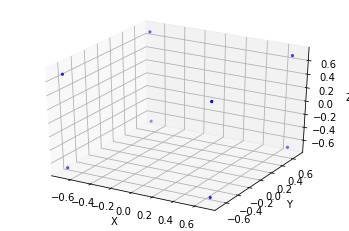

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = 'b', marker = '.') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [58]:
print(x[3],y[3],z[3])
print(x[7],y[7],z[7])

0.6891168669011327 0.6891168669011327 -0.6891168669011327
0.6891168669011327 0.6891168669011327 0.6891168669011327


In [59]:
#print("dato:",(l_repulsive / l_attractive)**(1.0 / (l_repulsive - l_attractive)))
for T in range(therm_time):
    #print("fuerza:", T, z_force[3], z_force[7])
    position()
    energy = force(T)
    #print("fuerza:", T, z_force[2], z_force[6])
    epotn = energy / num_of_particles
    if T%10000 == 0:
        print(T, epotn, 'Thermalization')
    #exit(0)

0 0.0 Thermalization
Fuerza: 1.0189026988191914 2.591680456386157
Fuerza: 1.0098486154454072 28.658576858665178
Fuerza: 1.0009114786417928 83.26469512652469
Fuerza: 0.9920944489012702 189.87690228196783
Fuerza: 0.9834007568171026 388.7858896172519
Problema: 38 2 6


SystemExit: 0

Text(0.5, 0, 'Z')

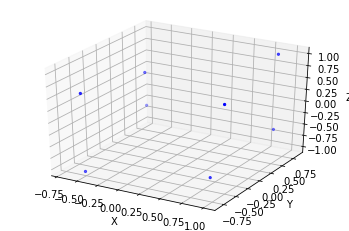

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c = 'b', marker = '.') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [35]:
print(x[3],y[3],z[3])
print(x[7],y[7],z[7])

1.0381164937202334 1.0898600452905223 -0.5912082244960912
1.1176653553582367 1.0170673186301704 -1.3429428685578522


In [ ]:
pbc = 0.0

for i in range(nconf):
    x, y, z = position(num_of_particles, box_length, x, y, z, x_force, y_force, z_force, delta_t, pbc, iseed)
    energy, x_force, y_force, z_force = force(x, y, z, box_length, cut_ratio, l_repulsive, l_attractive, a2, epi)
    epotn = energy / num_of_particles
    if i%10000 == 0:
        print(i, epotn / num_of_particles, 'Average')
    if i%ncep == 0:
        nprom += 1
        t[nprom] = delta_t * ncep * (nprom - 1)
        for j in range(num_of_particles):
            cfx[nprom][j] = x[j]
            cfy[nprom][j] = y[j]
            cfz[nprom][j] = z[j]
        gr(x, y, z, g, dr, num_of_particles, r_partition, box_length, cut_ratio)